In [1]:
import matplotlib.pyplot as plt


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from pathlib import Path
import sys
sys.path.append(str(Path.cwd() / "_scripts"))

In [74]:
import networkx as nx
from eppy.bunch_subclass import EpBunch
from geomeppy import IDF
import seaborn as sns
import polars as pl
import numpy as np
# from datetime import datetime
# from ladybug.dt import DateTime
# from matplotlib.patches import FancyArrowPatch
# from itertools import accumulate

from case_edits.ezcase import *
# from helpers.ep_helpers import *
# from helpers.ep_geom_helpers import *
# from helpers.geometry_interfaces import *
# from helpers.helpers import *
# from plan.helpers import get_plans_from_file
# from network.network import *
# from network.visuals import *
# from subsurfaces.logic import get_connecting_surface
# from helpers.read_sql import *

# from case_edits.epcase import EneryPlusCaseEditor
# from helpers.output_requests import request_sql

from helpers.variables import *
from helpers.variable_interfaces import *
from setup.setup import get_case_names, CaseData, retrieve_cases
from setup.plots import *
from setup.data_wrangle import *
from network.data_on_network import *

import matplotlib.cm as cm
import matplotlib as mpl


from matplotlib.colors import Colormap, Normalize, LinearSegmentedColormap
from setup.setup import create_directories

from helpers.ep_helpers import WallNormal
from subsurfaces.creator import SubsurfaceCreator

In [ ]:
# pairs = get_subsurface_pairs_from_case(path_to_inputs)
# pairs

In [141]:
qoi1 = 'AFN Linkage Node 1 to Node 2 Volume Flow Rate'
qoi12 = 'AFN Linkage Node 2 to Node 1 Volume Flow Rate'

qoi2 = "Site Wind Speed"
qoi3 = "Site Wind Direction"

qoi4 = all_variables.afn.zone["ach"]
qois = [qoi1, qoi12]

In [91]:
case_data = retrieve_cases()
sample_case  = case_data[0]
case_name, idf, sql, path_to_input, path_to_output = sample_case

In [135]:
pairs = get_subsurface_pairs_from_case(sample_case.path_to_input)
pairs

[SSP(pair=(1, 9), type=DOOR, dims=(0.81, 2.03),
 SSP(pair=(1, 8), type=DOOR, dims=(0.81, 2.03),
 SSP(pair=(9, 7), type=DOOR, dims=(0.81, 2.03),
 SSP(pair=(9, 8), type=DOOR, dims=(0.81, 2.03),
 SSP(pair=(9, 6), type=DOOR, dims=(0.81, 2.03),
 SSP(pair=(8, 6), type=DOOR, dims=(0.81, 2.03),
 SSP(pair=(8, 10), type=DOOR, dims=(0.81, 2.03),
 SSP(pair=(10, 2), type=DOOR, dims=(0.81, 2.03),
 SSP(pair=(10, 3), type=DOOR, dims=(0.81, 2.03),
 SSP(pair=(10, 0), type=DOOR, dims=(0.81, 2.03),
 SSP(pair=(5, 8), type=DOOR, dims=(0.81, 2.03),
 SSP(pair=(<WallNormal.WEST: 270.0>, 1), type=WINDOW, dims=(0.71, 1.52),
 SSP(pair=(4, 0), type=DOOR, dims=(0.81, 2.03),
 SSP(pair=(0, <WallNormal.NORTH: 0.0>), type=WINDOW, dims=(0.71, 1.52),
 SSP(pair=(3, <WallNormal.NORTH: 0.0>), type=WINDOW, dims=(0.71, 1.52),
 SSP(pair=(<WallNormal.SOUTH: 180.0>, 1), type=WINDOW, dims=(0.71, 1.52)]

In [148]:
Gm, pos = init_multigraph(sample_case.idf, sample_case.path_to_input)
Gm

In [149]:
df = create_dataframe_for_all_cases(case_data, qois[0])
df1 = join_any_data(df, case_data, qois[1])
df2 = join_site_data(sample_case, qoi3, df1, 1 )
df3 = df2.with_columns(linkage=pl.col("values") - pl.col("values_0"))

df_case = df3.filter(pl.col("case_names") == sample_case.case_name)
medians = df_case.group_by(pl.col("space_names")).agg(
        pl.col(["values", "values_0", "linkage"]).median()
    )
medians

space_names,values,values_0,linkage
str,f64,f64,f64
"""BLOCK 09 STOREY 0 WALL 0002_2 …",0.041048,0.129225,-0.069141
"""BLOCK 03 STOREY 0 WALL 0002 WI…",0.010175,0.230215,-0.20746
"""BLOCK 010 STOREY 0 WALL 0002_1…",0.003296,0.219314,-0.212445
"""BLOCK 01 STOREY 0 WALL 0003 WI…",0.048745,0.292995,-0.282426
"""BLOCK 010 STOREY 0 WALL 0002_2…",0.014386,0.224106,-0.207465
…,…,…,…
"""BLOCK 08 STOREY 0 WALL 0002_1 …",0.0,0.411991,-0.411991
"""BLOCK 01 STOREY 0 WALL 0001_2 …",0.042763,0.249457,-0.209341
"""BLOCK 09 STOREY 0 WALL 0002_1 …",0.020381,0.141742,-0.127318


In [154]:
def get_matching_edge(G: nx.MultiDiGraph, subsurface_name: str, value:float):
    consider_reverse = True if value >= 0 else False
    print(value, consider_reverse)
    for e in G.edges:
        if consider_reverse:
            if G.edges[e].get("reverse"):
                if G.edges[e].get("subsurfaces").upper() == subsurface_name:
                    return e
        else:
            if G.edges[e].get("subsurfaces").upper() == subsurface_name:
                    return e

    raise Exception(f"No match for {subsurface_name} in {G.edges}")

In [155]:
[get_matching_edge(Gm, s, v) for s, v in zip(medians["space_names"], medians["linkage"])]

-0.06914119241380359 False
-0.20746008403522534 False
-0.21244519614003368 False
-0.28242590551230295 False
-0.2074646263508837 False
-0.20643193140083455 False
-0.21244060167133402 False
-0.4119909992772703 False
-0.20934085700692143 False
-0.12731836028192628 False
0.12731848579355162 True
0.6398376676926436 True


[('9-e_living', '8-transit', 0),
 ('NORTH', '3-bed_1', 0),
 ('0-w_bed', '10-transit2', 0),
 ('1-w_living', 'WEST', 0),
 ('3-bed_1', '10-transit2', 0),
 ('1-w_living', '8-transit', 0),
 ('0-w_bed', 'NORTH', 0),
 ('8-transit', '10-transit2', 0),
 ('1-w_living', '9-e_living', 0),
 ('9-e_living', '6-den', 0),
 ('6-den', '8-transit', 0),
 ('1-w_living', 'SOUTH', 0)]

0.26991540405933656 True
-0.20533452922669063 False
-0.20106067236514166 False
-0.054161244678025175 False
-0.2007236149410416 False
0.03586354080510318 True
-0.15468762945109216 False
-0.20533059357962943 False
0.054161244170803605 True
-0.40639520099301574 False
-0.020575638864952187 False
-0.20105682097191088 False
0.3286687847776069 True
-0.3286679750485087 False
-0.6214731531435453 False
-1.4691255014425453 False
0.7001961728238317 True
-0.8575426741157504 False
0.9818108220523505 True
-0.7435946490135996 False
-0.7435808950508516 False
-0.8822027825003393 False
-0.48288378870913984 False
-0.8575586781465632 False


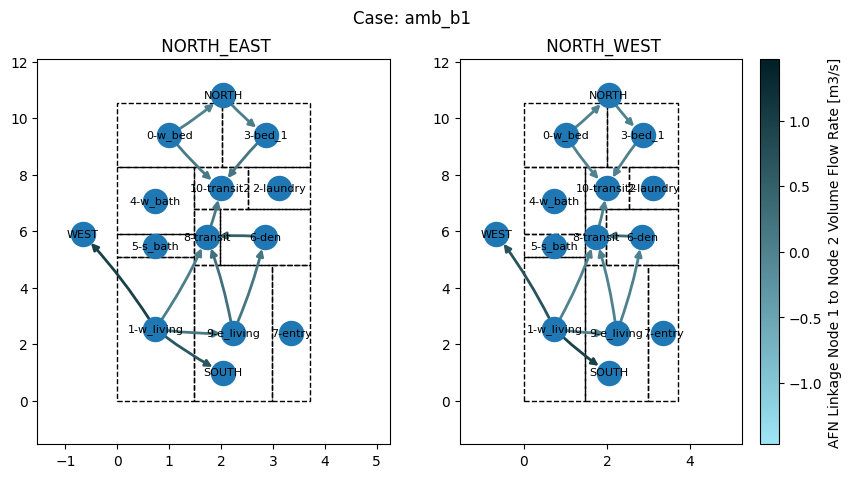

In [161]:
fig = create_data_on_network_fig_facet_winddir(case_data, sample_case, qois)
